#II užduotis (Vieno neurono mokymas sprendžiant klasifikavimo uždavinį) OLD

In [1]:

import csv, time, os
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/breast+cancer+wisconsin+original/breast-cancer-wisconsin.data"

Mounted at /content/drive


In [2]:
def load_data(path: str):
    rows = []
    with open(path, "r") as f:
        for r in csv.reader(f):
            if r and len(r) == 11 and "?" not in r[1:10]:
                rows.append(r) # Išsisaugome tik tas eilutes kurios neturi jokių '?'

    X, y = [], []
    for r in rows:
        feats = list(map(float, r[1:10])) # Atmetame ID (pirma stulpeli)
        label = 0 if r[10].strip() == "2" else 1 # Klases keiciame nepiktybinis navikas (2) -> 0, piktybinis (4) -> 1
        X.append(feats) # Sudarome duomenu aibę
        y.append(label) # Sudarome klasių aibę

    X = np.array(X) # Duomenis paverciame i matrica
    y = np.array(y).reshape(-1,1) # Klases paverciam stulpeliu

    idx = np.random.permutation(len(y)) # atsitiktinė eil. tvarka
    X, y = X[idx], y[idx] # pritaikome tą pačią tvarką X ir y

    return X, y

X, y = load_data(path)

In [3]:
# Punktas 2: modelis + mokymas/validavimas/testas (BGD (batch gradient descent) ir SGD (stochastic gradient descent))

# Pagalbinės funkcijos
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))  # sigmoidinė funkcija (nuo 0 iki 1)

def bce_loss(y_true, y_pred, eps=1e-12): # binarinė kryžminė entropija (BCE - Paklaida)
    y_pred = np.clip(y_pred, eps, 1.0 - eps) # apkarpone prognozes į [eps, 1−eps], kad neabūtų log(0) ar log(1)
    return float(-(y_true*np.log(y_pred) + (1.0 - y_true)*np.log(1.0 - y_pred)).mean())

def accuracy(y_true, y_pred): # klasifikavimo tikslumas (0 arba 1)
    y_cls = np.rint(y_pred).astype(int)
    return float((y_cls == y_true).mean())

def split_dataset(X, y, ratios=(0.8, 0.1, 0.1)): # daliname duomenis 80/10/10
    n = len(y);
    a = int(n*ratios[0]);
    b = a + int(n*ratios[1])
    return X[:a], y[:a], X[a:b], y[a:b], X[b:], y[b:]

In [4]:
# Neurono modelis (supaprastintas)
class SigmoidNeuron:
  def __init__(self, input_dim=9, learning_rate=0.002):
      self.lr = learning_rate # mokymosi greitis
      self.w  = np.random.normal(0.0, 0.01, (input_dim,1)) # svoriai (9×1 stulpelis)
      self.b  = 0.0 # poslinkis (bias)

  def forward(self, X):
      return sigmoid(X @ self.w + self.b) # prognozės [0,1] (N×1)

  def train(self, X_train, y_train, X_val, y_val, epochs=120, mode="bgd"):
      hist = {"train_bce": [], "val_bce": [], "train_acc": [], "val_acc": []}  # metrikų istorija
      t0 = time.perf_counter()  # startuojame laiką

      for _ in range(epochs):  # kartojame epochas
          if mode == "sgd":  # SGD: atnaujiname po vieną įrašą
              for i in np.random.permutation(len(X_train)):  # kiekvieną epochą sumaišome eiles
                  x = X_train[i:i+1, :]  # imame eilute
                  y = y_train[i:i+1, :]  # imame eilute
                  y_pred = self.forward(x)  # prognozė
                  delta = y_pred - y  # paklaida
                  self.w -= self.lr * (x.T @ delta)  # atnaujinami svoriai
                  self.b -= self.lr * float(delta.mean())  # atnaujinamas poslinkis
          else:  # BGD: vienas atnaujinimas per epochą
              y_pred = self.forward(X_train)  # prognozės N×1
              delta = y_pred - y_train  # paklaida
              self.w -= self.lr * ((X_train.T @ delta) / len(X_train))  # atnaujinami svoriai (vidurkinam per N)
              self.b -= self.lr * float(delta.mean())  # atnaujinamas poslinkis

          y_tr = self.forward(X_train); y_v = self.forward(X_val)  # prognozės metrikoms
          hist["train_bce"].append(bce_loss(y_train, y_tr))  # mokymo paklaida
          hist["val_bce"].append(bce_loss(y_val, y_v))  # validavimo paklaida
          hist["train_acc"].append(accuracy(y_train, y_tr))  # mokymo tikslumas
          hist["val_acc"].append(accuracy(y_val, y_v))  # validavimo tikslumas

      t1 = time.perf_counter()  # sustabdome laiką
      return hist, (t1 - t0)  # grąžiname metrikas ir mokymo laiką

In [5]:
# Daliname į 80/10/10 (mokymas/validavimas/testavimas)
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y, ratios=(0.8, 0.1, 0.1))

# Nustatome mokymosi greitį (Learning Rate - LR) ir epochų skaičių
learning_rate = 0.002
epochs = 100

# Kuriame du modelius (su tuo pačiu LR ir epochų skaičiumi): BGD ir SGD
model_bgd = SigmoidNeuron(input_dim=X.shape[1], learning_rate=learning_rate)
model_sgd = SigmoidNeuron(input_dim=X.shape[1], learning_rate=learning_rate)

# Mokome abu modelius ir kaupiame metrikas, fiksuojame mokymo laiką
hist_bgd, time_bgd = model_bgd.train(X_train, y_train, X_val, y_val, epochs=epochs, mode="bgd")  # BGD
hist_sgd, time_sgd = model_sgd.train(X_train, y_train, X_val, y_val, epochs=epochs, mode="sgd")  # SGD

# Testo metrikos abiem atvejams (BCE, tikslumas)
def eval_test(model, X_t, y_t):
  y_p = model.forward(X_t)
  return bce_loss(y_t, y_p), accuracy(y_t, y_p)

bgd_bce, bgd_acc = eval_test(model_bgd, X_test, y_test)
sgd_bce, sgd_acc = eval_test(model_sgd, X_test, y_test)

# Išvedamas
print("— PAKETINIS GRADIENTINIS NUSILEIDIMAS (BGD):")
print("Svoriai (9):", np.array2string(model_bgd.w.ravel(), precision=6, separator=", "))
print("Poslinkis (bias):", float(model_bgd.b))
print("Mokymas (paskutinė epocha):  Paklaida=%.6f  Tikslumas=%.4f" % (hist_bgd["train_bce"][-1], hist_bgd["train_acc"][-1])) # [-1] = x[len(x)-1]
print("Validavimas (paskutinė):     Paklaida=%.6f  Tikslumas=%.4f" % (hist_bgd["val_bce"][-1],   hist_bgd["val_acc"][-1]))
print("Testas:                      Paklaida=%.6f  Tikslumas=%.4f" % (bgd_bce, bgd_acc))
print("Mokymo laikas (s): %.4f" % time_bgd)

print("\n— STOCHASTINIS GRADIENTINIS NUSILEIDIMAS (SGD):")
print("Svoriai (9):", np.array2string(model_sgd.w.ravel(), precision=6, separator=", "))
print("Poslinkis (bias):", float(model_sgd.b))
print("Mokymas (paskutinė epocha):  Paklaida=%.6f  Tikslumas=%.4f" % (hist_sgd["train_bce"][-1], hist_sgd["train_acc"][-1]))
print("Validavimas (paskutinė):     Paklaida=%.6f  Tikslumas=%.4f" % (hist_sgd["val_bce"][-1],   hist_sgd["val_acc"][-1]))
print("Testas:                      Paklaida=%.6f  Tikslumas=%.4f" % (sgd_bce, sgd_acc))
print("Mokymo laikas (s): %.4f" % time_sgd)

— PAKETINIS GRADIENTINIS NUSILEIDIMAS (BGD):
Svoriai (9): [-0.031071,  0.020541,  0.043564,  0.03212 , -0.039368,  0.061504,
  0.010543,  0.03581 ,  0.00023 ]
Poslinkis (bias): -0.0454549627845533
Mokymas (paskutinė epocha):  Paklaida=0.604604  Tikslumas=0.5458
Validavimas (paskutinė):     Paklaida=0.585032  Tikslumas=0.5735
Testas:                      Paklaida=0.573820  Tikslumas=0.5797
Mokymo laikas (s): 0.0212

— STOCHASTINIS GRADIENTINIS NUSILEIDIMAS (SGD):
Svoriai (9): [ 0.127817,  0.29496 ,  0.258161,  0.1632  , -0.17895 ,  0.339247,
  0.029217,  0.247357,  0.092114]
Poslinkis (bias): -4.728354040310451
Mokymas (paskutinė epocha):  Paklaida=0.116072  Tikslumas=0.9670
Validavimas (paskutinė):     Paklaida=0.086217  Tikslumas=0.9853
Testas:                      Paklaida=0.089336  Tikslumas=0.9710
Mokymo laikas (s): 1.1652


Iš pradžių reikia paskaičiuoti TP, TN, FP, FN. Tada galima skaičiuoti tikslumą (_accuracy_), atkūrimą (_recall_), preciziškumą (_precision_), F1.

$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$ – Parodo, kokia dalis prognozių buvo teisingos.

$Recall = \frac{TP}{TP + FN}$ – Parodo, kiek iš visų teigiamai prognozuotų atvejų buvo tikrai teisingi.

$Precision = \frac{TP}{TP + FP}$ – Parodo, kiek teisingai atpažintų teigiamų atvejų iš visų esamų teigiamų.

$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$ – Harmoninis vidurkis tarp precizijos ir atkūrimo.

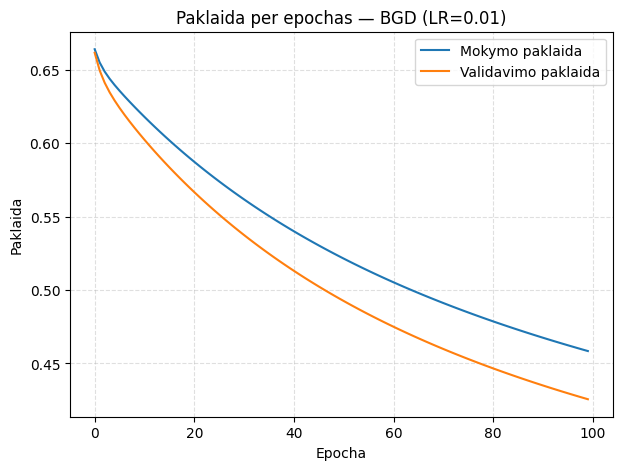

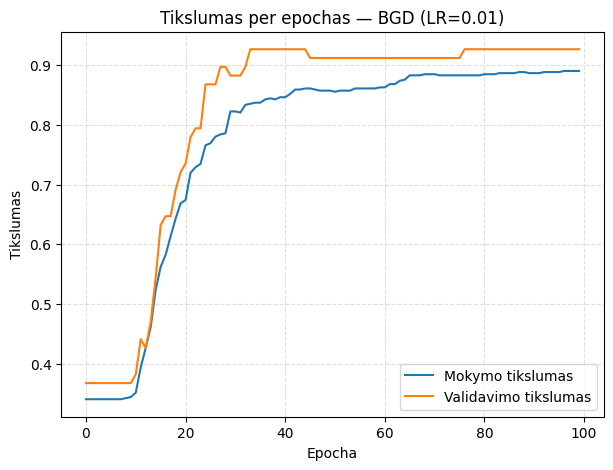

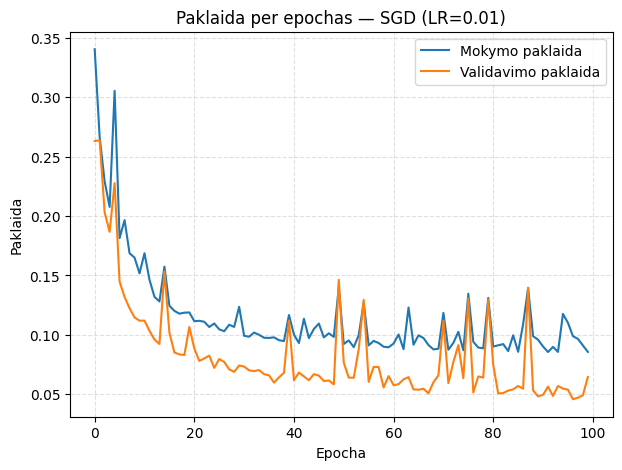

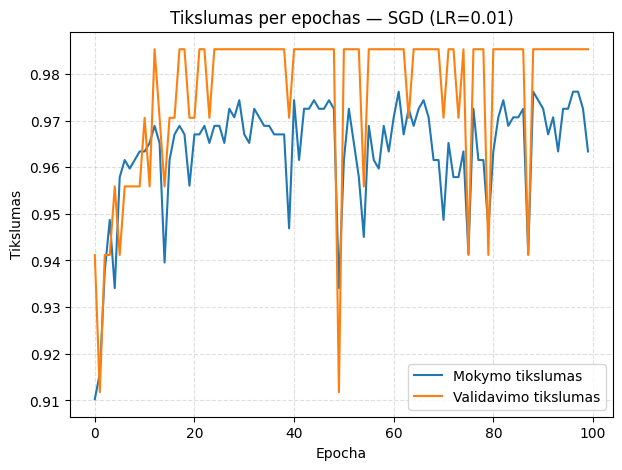

In [6]:
# 3.1: paleidžiame eksperimentus abiem metodams ir keliems LR; saugome rezultatus

def run_one(mode, lr, epochs):  # vienas eksperimentas
    model = SigmoidNeuron(input_dim=X.shape[1], learning_rate=lr)  # modelis
    hist, t = model.train(X_train, y_train, X_val, y_val, epochs=epochs, mode=mode)  # mokymas
    y_test_pred = model.forward(X_test)  # test tikimybės
    return {
        "mode": mode, "lr": lr, "hist": hist, "time": t,                 # istorija + laikas
        "test_bce": bce_loss(y_test, y_test_pred),                       # test paklaida
        "test_acc": accuracy(y_test, y_test_pred),                       # test tikslumas
        "w": model.w.copy(), "b": float(model.b)                         # svoriai ir bias
    }

# pasirenkame bent 3 LR
lrs = [0.001, 0.002, 0.01]  # paprasta trijulė
results = []
for mode in ["bgd", "sgd"]:
    for lr in lrs:
        results.append(run_one(mode, lr, epochs))  # vykdom ekspermentus

# 3.2: geriausias BGD ir geriausias SGD (pagal paskutinės epochos validavimo tikslumą; lygybėje – mažesnė val BCE)

def last_val_acc(r): return r["hist"]["val_acc"][-1] # paskutinės epochos val tikslumas
def last_val_bce(r): return r["hist"]["val_bce"][-1] # paskutinės epochos val paklaida

best_bgd = sorted([r for r in results if r["mode"]=="bgd"],
                  key=lambda r: (-last_val_acc(r), last_val_bce(r)))[0]
best_sgd = sorted([r for r in results if r["mode"]=="sgd"],
                  key=lambda r: (-last_val_acc(r), last_val_bce(r)))[0]

# Braižome BGD
h = best_bgd["hist"]; ttl = f'BGD (LR={best_bgd["lr"]})'
plt.figure(figsize=(7,5))
plt.plot(h["train_bce"], label="Mokymo paklaida")  # mokymo paklaida
plt.plot(h["val_bce"],   label="Validavimo paklaida")  # validavimo paklaida
plt.xlabel("Epocha"); plt.ylabel("Paklaida"); plt.title(f"Paklaida per epochas — {ttl}")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

plt.figure(figsize=(7,5))
plt.plot(h["train_acc"], label="Mokymo tikslumas")  # mokymo tikslumas
plt.plot(h["val_acc"],   label="Validavimo tikslumas")  # validavimo tikslumas
plt.xlabel("Epocha"); plt.ylabel("Tikslumas"); plt.title(f"Tikslumas per epochas — {ttl}")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

# Braižome SGD
h = best_sgd["hist"]; ttl = f'SGD (LR={best_sgd["lr"]})'
plt.figure(figsize=(7,5))
plt.plot(h["train_bce"], label="Mokymo paklaida")
plt.plot(h["val_bce"],   label="Validavimo paklaida")
plt.xlabel("Epocha"); plt.ylabel("Paklaida"); plt.title(f"Paklaida per epochas — {ttl}")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

plt.figure(figsize=(7,5))
plt.plot(h["train_acc"], label="Mokymo tikslumas")
plt.plot(h["val_acc"],   label="Validavimo tikslumas")
plt.xlabel("Epocha"); plt.ylabel("Tikslumas"); plt.title(f"Tikslumas per epochas — {ttl}")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

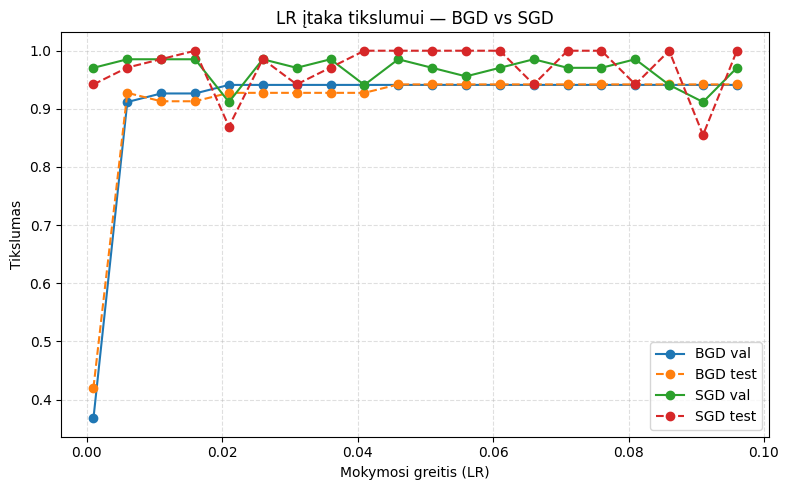

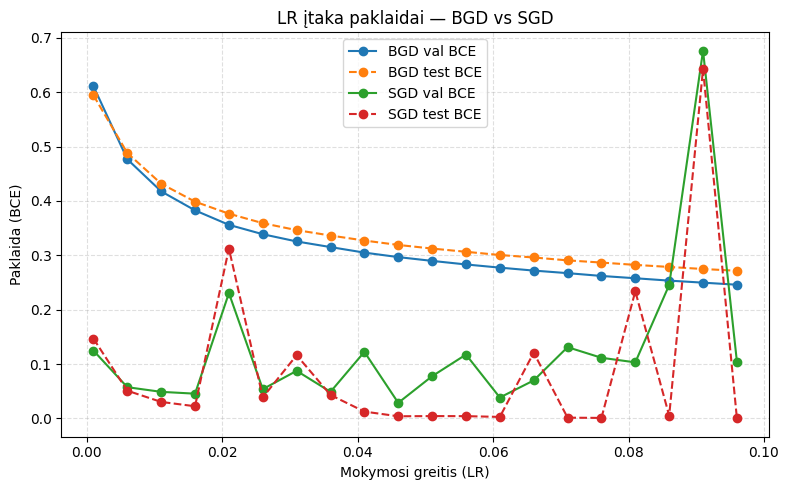

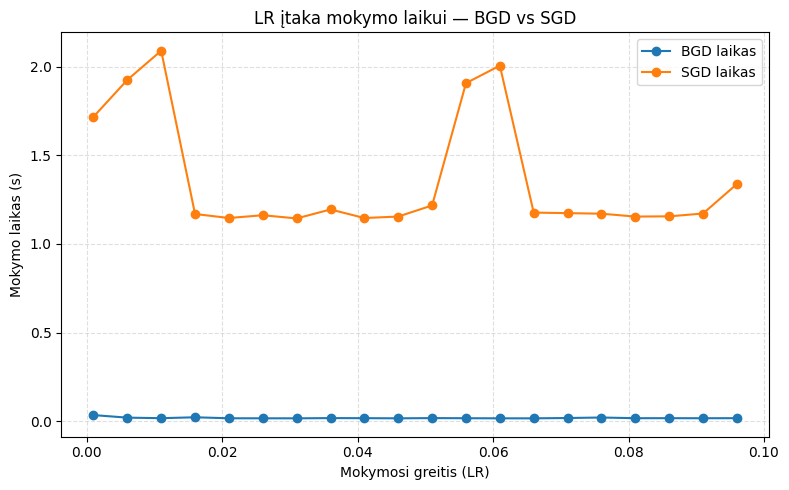

In [7]:
# 3.3: Kombinuotos diagramos (BGD vs SGD) su test reikšmėmis; LR ∈ [0.001..0.1] kas 0.005

# LR sąrašas (linijinis)
lrs = [round(x, 3) for x in np.arange(0.001, 0.101, 0.005)]

# Vykdome bandymus (naudojame jau turimą run_one(...) ir epochs)
res = {m: [run_one(m, lr, epochs) for lr in lrs] for m in ("bgd", "sgd")}  # rezultatai abiem metodams

# Greita pagalbinė serijų rinkėja
def series(mode, key):
    a = res[mode]
    if key == "val_acc":  return [r["hist"]["val_acc"][-1] for r in a]
    if key == "val_bce":  return [r["hist"]["val_bce"][-1] for r in a]
    if key == "test_acc": return [r["test_acc"] for r in a]
    if key == "test_bce": return [r["test_bce"] for r in a]
    if key == "time":     return [r["time"] for r in a]

# 1) LR → tikslumas (validavimas + test)
plt.figure(figsize=(8,5))
plt.plot(lrs, series("bgd","val_acc"),  marker="o", label="BGD val")
plt.plot(lrs, series("bgd","test_acc"), marker="o", linestyle="--", label="BGD test")
plt.plot(lrs, series("sgd","val_acc"),  marker="o", label="SGD val")
plt.plot(lrs, series("sgd","test_acc"), marker="o", linestyle="--", label="SGD test")
plt.xlabel("Mokymosi greitis (LR)"); plt.ylabel("Tikslumas"); plt.title("LR įtaka tikslumui — BGD vs SGD")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

# 2) LR → paklaida (BCE) (validavimas + test)
plt.figure(figsize=(8,5))
plt.plot(lrs, series("bgd","val_bce"),  marker="o", label="BGD val BCE")
plt.plot(lrs, series("bgd","test_bce"), marker="o", linestyle="--", label="BGD test BCE")
plt.plot(lrs, series("sgd","val_bce"),  marker="o", label="SGD val BCE")
plt.plot(lrs, series("sgd","test_bce"), marker="o", linestyle="--", label="SGD test BCE")
plt.xlabel("Mokymosi greitis (LR)"); plt.ylabel("Paklaida (BCE)"); plt.title("LR įtaka paklaidai — BGD vs SGD")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

# 3) LR → mokymo laikas
plt.figure(figsize=(8,5))
plt.plot(lrs, series("bgd","time"), marker="o", label="BGD laikas")
plt.plot(lrs, series("sgd","time"), marker="o", label="SGD laikas")
plt.xlabel("Mokymosi greitis (LR)"); plt.ylabel("Mokymo laikas (s)"); plt.title("LR įtaka mokymo laikui — BGD vs SGD")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

In [8]:
# 3.4: santraukos lentelė (metodas × LR) su validavimo ir testo rodikliais + laikas

def row(r):
    return (f'{r["mode"].upper()}  LR={r["lr"]}:  '
            f'ValAcc={last_val_acc(r):.4f}  ValBCE={last_val_bce(r):.6f}  '
            f'TestAcc={r["test_acc"]:.4f}  TestBCE={r["test_bce"]:.6f}  '
            f'Time={r["time"]:.3f}s')

for r in sorted(results, key=lambda x: (x["mode"], x["lr"])):
    print(row(r))

print("\n— Geriausi variantai —")
print("BGD:", row(best_bgd))
print("SGD:", row(best_sgd))

BGD  LR=0.001:  ValAcc=0.3676  ValBCE=0.619052  TestAcc=0.4203  TestBCE=0.598286  Time=0.021s
BGD  LR=0.002:  ValAcc=0.7353  ValBCE=0.561479  TestAcc=0.6667  TestBCE=0.556478  Time=0.016s
BGD  LR=0.01:  ValAcc=0.9265  ValBCE=0.425640  TestAcc=0.9130  TestBCE=0.438620  Time=0.016s
SGD  LR=0.001:  ValAcc=0.9706  ValBCE=0.123678  TestAcc=0.9420  TestBCE=0.143974  Time=1.133s
SGD  LR=0.002:  ValAcc=0.9706  ValBCE=0.097679  TestAcc=0.9420  TestBCE=0.115319  Time=1.173s
SGD  LR=0.01:  ValAcc=0.9853  ValBCE=0.064579  TestAcc=0.9565  TestBCE=0.063632  Time=1.243s

— Geriausi variantai —
BGD: BGD  LR=0.01:  ValAcc=0.9265  ValBCE=0.425640  TestAcc=0.9130  TestBCE=0.438620  Time=0.016s
SGD: SGD  LR=0.01:  ValAcc=0.9853  ValBCE=0.064579  TestAcc=0.9565  TestBCE=0.063632  Time=1.243s


In [9]:
print("\nBGD: mokymo ir validavimo Paklaida per epochas")
for i, (tr, va) in enumerate(zip(hist_bgd["train_bce"], hist_bgd["val_bce"]), 1):
    print(f"Epocha {i:3d}: Train={tr:.6f}  Val={va:.6f}")

print("\nSGD: mokymo ir validavimo Paklaida per epochas")
for i, (tr, va) in enumerate(zip(hist_sgd["train_bce"], hist_sgd["val_bce"]), 1):
    print(f"Epocha {i:3d}: Train={tr:.6f}  Val={va:.6f}")


BGD: mokymo ir validavimo Paklaida per epochas
Epocha   1: Train=0.741530  Val=0.753720
Epocha   2: Train=0.732230  Val=0.742805
Epocha   3: Train=0.724036  Val=0.733117
Epocha   4: Train=0.716816  Val=0.724511
Epocha   5: Train=0.710447  Val=0.716859
Epocha   6: Train=0.704820  Val=0.710043
Epocha   7: Train=0.699837  Val=0.703956
Epocha   8: Train=0.695413  Val=0.698505
Epocha   9: Train=0.691471  Val=0.693610
Epocha  10: Train=0.687948  Val=0.689197
Epocha  11: Train=0.684785  Val=0.685204
Epocha  12: Train=0.681935  Val=0.681578
Epocha  13: Train=0.679353  Val=0.678270
Epocha  14: Train=0.677005  Val=0.675240
Epocha  15: Train=0.674858  Val=0.672452
Epocha  16: Train=0.672885  Val=0.669876
Epocha  17: Train=0.671064  Val=0.667486
Epocha  18: Train=0.669373  Val=0.665259
Epocha  19: Train=0.667796  Val=0.663174
Epocha  20: Train=0.666319  Val=0.661215
Epocha  21: Train=0.664927  Val=0.659366
Epocha  22: Train=0.663611  Val=0.657616
Epocha  23: Train=0.662360  Val=0.655951
Epocha  2

In [11]:
# BGD geriausias
y_prob_bgd = sigmoid(X_test @ best_bgd["w"] + best_bgd["b"]).ravel()
y_pred_bgd = (y_prob_bgd >= 0.5).astype(int)

print("\n=== BGD testavimo rezultatai ===")
for i in range(len(y_test)):
    print(f"Įrašas {i+1:2d}: tikra={int(y_test[i,0])}  prognozė={y_pred_bgd[i]}  (tikimybė={y_prob_bgd[i]:.4f})")

# SGD geriausias
y_prob_sgd = sigmoid(X_test @ best_sgd["w"] + best_sgd["b"]).ravel()
y_pred_sgd = (y_prob_sgd >= 0.5).astype(int)

print("\n=== SGD testavimo rezultatai ===")
for i in range(len(y_test)):
    print(f"Įrašas {i+1:2d}: tikra={int(y_test[i,0])}  prognozė={y_pred_sgd[i]}  (tikimybė={y_prob_sgd[i]:.4f})")


=== BGD testavimo rezultatai ===
Įrašas  1: tikra=0  prognozė=0  (tikimybė=0.4477)
Įrašas  2: tikra=1  prognozė=1  (tikimybė=0.7856)
Įrašas  3: tikra=1  prognozė=0  (tikimybė=0.3595)
Įrašas  4: tikra=0  prognozė=0  (tikimybė=0.4477)
Įrašas  5: tikra=1  prognozė=0  (tikimybė=0.4850)
Įrašas  6: tikra=1  prognozė=1  (tikimybė=0.9721)
Įrašas  7: tikra=1  prognozė=1  (tikimybė=0.5758)
Įrašas  8: tikra=0  prognozė=1  (tikimybė=0.5163)
Įrašas  9: tikra=0  prognozė=0  (tikimybė=0.4256)
Įrašas 10: tikra=0  prognozė=0  (tikimybė=0.2342)
Įrašas 11: tikra=1  prognozė=1  (tikimybė=0.5444)
Įrašas 12: tikra=1  prognozė=1  (tikimybė=0.7634)
Įrašas 13: tikra=1  prognozė=1  (tikimybė=0.8624)
Įrašas 14: tikra=0  prognozė=1  (tikimybė=0.5360)
Įrašas 15: tikra=0  prognozė=0  (tikimybė=0.4256)
Įrašas 16: tikra=1  prognozė=0  (tikimybė=0.1474)
Įrašas 17: tikra=1  prognozė=1  (tikimybė=0.8586)
Įrašas 18: tikra=1  prognozė=1  (tikimybė=0.6974)
Įrašas 19: tikra=0  prognozė=0  (tikimybė=0.3353)
Įrašas 20: tikra

#II užduotis (Vieno neurono mokymas sprendžiant klasifikavimo uždavinį)

In [67]:
import csv, time
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/breast+cancer+wisconsin+original/breast-cancer-wisconsin.data"  # <- pakeiskite jei reikia

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Duomenų įkėlimas ir paruošimas
def load_data(path: str):
    rows = []
    with open(path, "r") as f:
        for r in csv.reader(f):
            # atmetam eilutes su '?'
            if r and len(r) == 11 and "?" not in r[1:10]:
                rows.append(r)
    X, y = [], []
    for r in rows:
        feats = list(map(float, r[1:10]))  # be ID stulpelio
        lab = int(r[10])
        if lab == 2: y.append(0)   # 2 -> 0
        elif lab == 4: y.append(1) # 4 -> 1
        else: continue
        X.append(feats)
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)

    idx = np.arange(len(X))
    np.random.shuffle(idx)
    return X[idx], y[idx]

X, y = load_data(PATH)

In [69]:
# 80:10:10 padalinimas (mokymas / validavimas / testas)
n = len(X)
n_train = int(0.8*n)
n_val   = int(0.1*n)
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

In [70]:
# Sigmoid, forward ir metrikos
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def forward(X, w, b):
    return sigmoid(X @ w + b)

def mse(y_true, y_hat):
    return np.mean((y_true - y_hat)**2)

def acc(y_true, y_prob):
    y_lab = (y_prob >= 0.5).astype(int)  # suapvalinimas į {0,1}
    return np.mean((y_lab == y_true).astype(float))

In [71]:
def train_sgd(X_tr, y_tr, X_va, y_va, lr=0.01, epochs=100, seed=0):
    rng = np.random.default_rng(seed)
    m, d = X_tr.shape
    w = rng.uniform(-0.01, 0.01, size=d); b = rng.uniform(-0.01, 0.01)
    hist_train_mse, hist_val_mse, hist_train_acc, hist_val_acc = [], [], [], []
    t0 = time.time()
    for _ in range(epochs):
        for i in rng.permutation(m):
            xi, ti = X_tr[i], y_tr[i]
            yi = 1.0/(1.0+np.exp(-(w@xi + b)))
            # SGD pagal skaidres: w_k ← w_k - η (y_i - t_i) y_i(1-y_i) x_{ik},  b ← b - η (y_i - t_i) y_i(1-y_i)
            gc = (yi - ti) * yi * (1.0 - yi)      # bendra dalis (y_i - t_i) y_i(1-y_i)
            w -= lr * gc * xi
            b -= lr * gc
        ytr = forward(X_tr, w, b); yva = forward(X_va, w, b)
        hist_train_mse.append(mse(y_tr, ytr)); hist_val_mse.append(mse(y_va, yva))
        hist_train_acc.append(acc(y_tr, ytr)); hist_val_acc.append(acc(y_va, yva))
    return w, b, np.array(hist_train_mse), np.array(hist_val_mse), np.array(hist_train_acc), np.array(hist_val_acc), (time.time()-t0)

In [72]:
def train_bgd(X_tr, y_tr, X_va, y_va, lr=0.01, epochs=100, seed=0):
    rng = np.random.default_rng(seed)
    m, d = X_tr.shape
    w = rng.uniform(-0.01, 0.01, size=d); b = rng.uniform(-0.01, 0.01)
    hist_train_mse, hist_val_mse, hist_train_acc, hist_val_acc = [], [], [], []
    t0 = time.time()
    for _ in range(epochs):
        yhat = forward(X_tr, w, b)
        # BGD pagal skaidres: grad_w = mean_i[(y_i - t_i) y_i(1-y_i) x_i],  grad_b = mean_i[(y_i - t_i) y_i(1-y_i)]
        diff = (yhat - y_tr) * yhat * (1.0 - yhat)   # vekt. (m,)
        grad_w = (X_tr * diff[:, None]).mean(axis=0) # ∇w
        grad_b = diff.mean()                          # ∇b
        w -= lr * grad_w
        b -= lr * grad_b
        ytr = forward(X_tr, w, b); yva = forward(X_va, w, b)
        hist_train_mse.append(mse(y_tr, ytr)); hist_val_mse.append(mse(y_va, yva))
        hist_train_acc.append(acc(y_tr, ytr)); hist_val_acc.append(acc(y_va, yva))
    return w, b, np.array(hist_train_mse), np.array(hist_val_mse), np.array(hist_train_acc), np.array(hist_val_acc), (time.time()-t0)

In [73]:
BASE_LR = 0.01
EPOCHS  = 100

w_sgd, b_sgd, tr_mse_sgd, va_mse_sgd, tr_acc_sgd, va_acc_sgd, time_sgd = train_sgd(X_train, y_train, X_val, y_val, lr=BASE_LR, epochs=EPOCHS, seed=0)
w_bgd, b_bgd, tr_mse_bgd, va_mse_bgd, tr_acc_bgd, va_acc_bgd, time_bgd = train_bgd(X_train, y_train, X_val, y_val, lr=BASE_LR, epochs=EPOCHS, seed=0)

In [74]:
# Testo paklaida ir tikslumas (ABU metodai)
yprob_sgd_test = forward(X_test, w_sgd, b_sgd)
yprob_bgd_test = forward(X_test, w_bgd, b_bgd)
test_mse_sgd = mse(y_test, yprob_sgd_test); test_acc_sgd = acc(y_test, yprob_sgd_test)
test_mse_bgd = mse(y_test, yprob_bgd_test); test_acc_bgd = acc(y_test, yprob_bgd_test)

print("==== SGD (bazinis LR) ====")
print(f"Svoriai (9): {w_sgd}\nBias: {b_sgd}")
print(f"Mokymo laikas: {time_sgd:.3f} s")
print(f"Train MSE={tr_mse_sgd[-1]:.6f}, Train ACC={tr_acc_sgd[-1]:.4f}")
print(f"Val   MSE={va_mse_sgd[-1]:.6f}, Val   ACC={va_acc_sgd[-1]:.4f}")
print(f"Test  MSE={test_mse_sgd:.6f}, Test  ACC={test_acc_sgd:.4f}")

print("\n==== BGD (bazinis LR) ====")
print(f"Svoriai (9): {w_bgd}\nBias: {b_bgd}")
print(f"Mokymo laikas: {time_bgd:.3f} s")
print(f"Train MSE={tr_mse_bgd[-1]:.6f}, Train ACC={tr_acc_bgd[-1]:.4f}")
print(f"Val   MSE={va_mse_bgd[-1]:.6f}, Val   ACC={va_acc_bgd[-1]:.4f}")
print(f"Test  MSE={test_mse_bgd:.6f}, Test  ACC={test_acc_bgd:.4f}")

==== SGD (bazinis LR) ====
Svoriai (9): [ 0.11412387  0.32469741  0.16701118  0.08972504 -0.16256179  0.26640909
 -0.03174745  0.22140956  0.09252568]
Bias: -3.9737283113348587
Mokymo laikas: 0.347 s
Train MSE=0.027283, Train ACC=0.9744
Val   MSE=0.048292, Val   ACC=0.9412
Test  MSE=0.022952, Test  ACC=0.9855

==== BGD (bazinis LR) ====
Svoriai (9): [-0.0546233   0.05116474  0.0377733   0.01392274 -0.03609763  0.08119165
 -0.021661    0.0469687  -0.02528295]
Bias: -0.04974738396172734
Mokymo laikas: 0.014 s
Train MSE=0.197489, Train ACC=0.7930
Val   MSE=0.196065, Val   ACC=0.7500
Test  MSE=0.184361, Test  ACC=0.8696


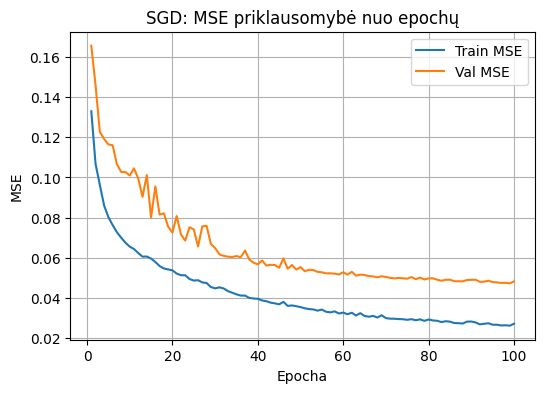

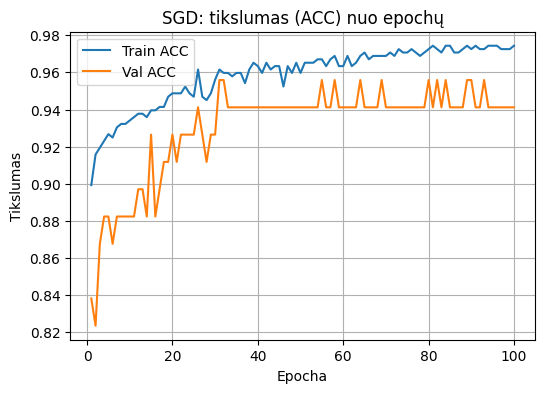

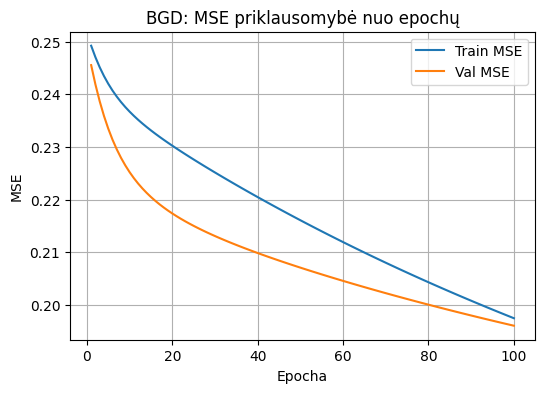

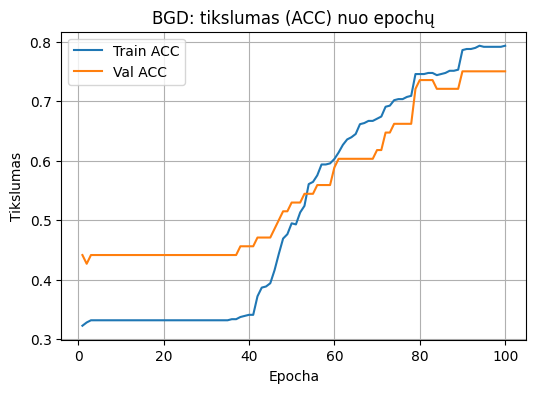

In [75]:
# GRAFIKAI — priklausomybės nuo epochų (baziniam LR)
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_mse_sgd, label="Train MSE")
plt.plot(epochs, va_mse_sgd, label="Val MSE")
plt.title("SGD: MSE priklausomybė nuo epochų")
plt.xlabel("Epocha"); plt.ylabel("MSE"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_acc_sgd, label="Train ACC")
plt.plot(epochs, va_acc_sgd, label="Val ACC")
plt.title("SGD: tikslumas (ACC) nuo epochų")
plt.xlabel("Epocha"); plt.ylabel("Tikslumas"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_mse_bgd, label="Train MSE")
plt.plot(epochs, va_mse_bgd, label="Val MSE")
plt.title("BGD: MSE priklausomybė nuo epochų")
plt.xlabel("Epocha"); plt.ylabel("MSE"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_acc_bgd, label="Train ACC")
plt.plot(epochs, va_acc_bgd, label="Val ACC")
plt.title("BGD: tikslumas (ACC) nuo epochų")
plt.xlabel("Epocha"); plt.ylabel("Tikslumas"); plt.legend(); plt.grid(True); plt.show()

In [76]:
# 3 skirtingi LR ir palyginimai (test MSE/ACC + mokymo laikas)
lr_list = [0.001, 0.01, 0.1]
results = []  # (method, lr, test_mse, test_acc, time)

for lr in lr_list:
    w, b, *_ , t = train_sgd(X_train, y_train, X_val, y_val, lr=lr, epochs=EPOCHS, seed=0)
    test_mse = mse(y_test, forward(X_test, w, b))
    test_acc = acc(y_test, forward(X_test, w, b))
    results.append(("SGD", lr, test_mse, test_acc, t))

    w, b, *_ , t = train_bgd(X_train, y_train, X_val, y_val, lr=lr, epochs=EPOCHS, seed=0)
    test_mse = mse(y_test, forward(X_test, w, b))
    test_acc = acc(y_test, forward(X_test, w, b))
    results.append(("BGD", lr, test_mse, test_acc, t))

# Pateikiame nedidelę lentelę konsolėje
print("\n=== LR tyrimas (testo rodikliai ir mokymo laikas) ===")
print("Metodas  LR       Test MSE     Test ACC     Laikas (s)")
for m, lr, tmse, tacc, tt in results:
    print(f"{m:6s}  {lr:<6}  {tmse:10.6f}   {tacc:9.4f}    {tt:8.3f}")

# Bar grafikai: test ACC, test MSE, mokymo laikas
def bar_data(metric_idx):
    # metric_idx: 2->Test MSE, 3->Test ACC, 4->Time
    sgd_vals = [r[metric_idx] for r in results if r[0]=="SGD"]
    bgd_vals = [r[metric_idx] for r in results if r[0]=="BGD"]
    return sgd_vals, bgd_vals

x = np.arange(len(lr_list))
width = 0.35


=== LR tyrimas (testo rodikliai ir mokymo laikas) ===
Metodas  LR       Test MSE     Test ACC     Laikas (s)
SGD     0.001     0.056087      0.9275       0.348
BGD     0.001     0.227262      0.4058       0.015
SGD     0.01      0.022952      0.9855       0.319
BGD     0.01      0.184361      0.8696       0.014
SGD     0.1       0.405808      0.5942       0.323
BGD     0.1       0.095333      0.9130       0.014


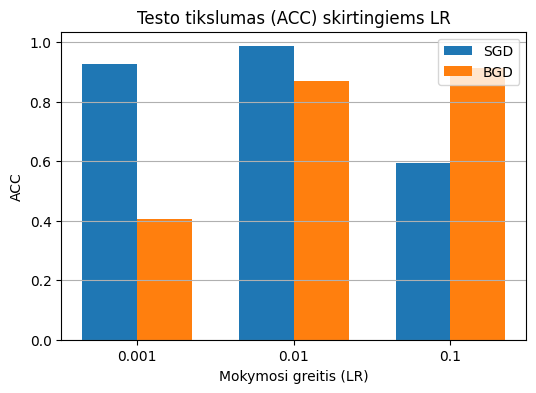

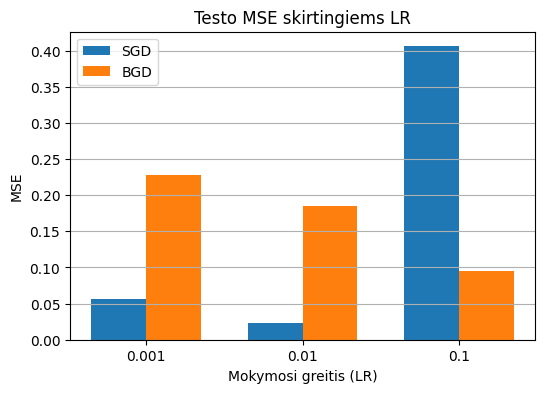

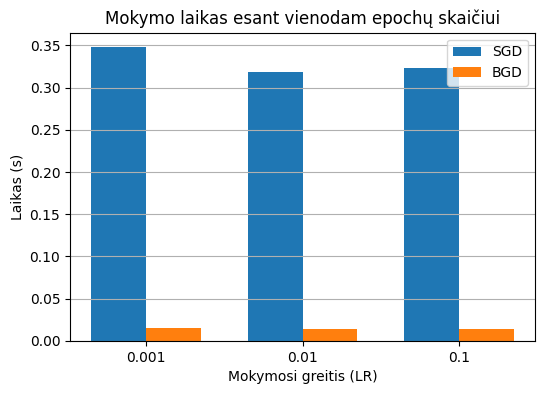

In [77]:
# Test ACC
sgd_acc, bgd_acc = bar_data(3)
plt.figure(figsize=(6,4))
plt.bar(x - width/2, sgd_acc, width, label="SGD")
plt.bar(x + width/2, bgd_acc, width, label="BGD")
plt.xticks(x, [str(lr) for lr in lr_list])
plt.title("Testo tikslumas (ACC) skirtingiems LR")
plt.xlabel("Mokymosi greitis (LR)"); plt.ylabel("ACC")
plt.legend(); plt.grid(True, axis='y'); plt.show()

# Test MSE
sgd_mse, bgd_mse = bar_data(2)
plt.figure(figsize=(6,4))
plt.bar(x - width/2, sgd_mse, width, label="SGD")
plt.bar(x + width/2, bgd_mse, width, label="BGD")
plt.xticks(x, [str(lr) for lr in lr_list])
plt.title("Testo MSE skirtingiems LR")
plt.xlabel("Mokymosi greitis (LR)"); plt.ylabel("MSE")
plt.legend(); plt.grid(True, axis='y'); plt.show()

# Mokymo laikas
sgd_t, bgd_t = bar_data(4)
plt.figure(figsize=(6,4))
plt.bar(x - width/2, sgd_t, width, label="SGD")
plt.bar(x + width/2, bgd_t, width, label="BGD")
plt.xticks(x, [str(lr) for lr in lr_list])
plt.title("Mokymo laikas esant vienodam epochų skaičiui")
plt.xlabel("Mokymosi greitis (LR)"); plt.ylabel("Laikas (s)")
plt.legend(); plt.grid(True, axis='y'); plt.show()

In [78]:
def spausdinti_testo_irasus_salia(y_true, yprob_sgd, yprob_bgd):
    import numpy as np
    y_true = np.asarray(y_true, int)
    yprob_sgd = np.asarray(yprob_sgd, float)
    yprob_bgd = np.asarray(yprob_bgd, float)
    ypred_sgd = (yprob_sgd >= 0.5).astype(int)
    ypred_bgd = (yprob_bgd >= 0.5).astype(int)

    n = len(y_true)
    w = len(str(n))  # numeracijos plotis
    fmt = f"{{:>{w}}}  {{:>5}}  {{:>8}}  {{:>9}}  {{:>8}}  {{:>9}}"

    header = fmt.format("#", "tikra", "SGD_prog", "SGD_prob", "BGD_prog", "BGD_prob")
    print(f"\nTesto įrašai (n={n}):")
    print(header); print("-" * len(header))

    for i, (t, ps, pb, pps, ppb) in enumerate(zip(y_true, ypred_sgd, ypred_bgd, yprob_sgd, yprob_bgd), 1):
        print(fmt.format(i, t, ps, f"{pps:.6f}", pb, f"{ppb:.6f}"))

spausdinti_testo_irasus_salia(y_test, yprob_sgd_test, yprob_bgd_test)


Testo įrašai (n=69):
 #  tikra  SGD_prog   SGD_prob  BGD_prog   BGD_prob
---------------------------------------------------
 1      1         1   0.961851         1   0.668441
 2      1         1   0.506196         1   0.640087
 3      1         1   0.980634         1   0.620939
 4      1         1   0.976909         1   0.655706
 5      0         0   0.047242         0   0.477407
 6      1         1   0.979675         1   0.667448
 7      0         0   0.045015         1   0.501878
 8      1         1   0.999375         1   0.757708
 9      0         0   0.054637         0   0.491703
10      1         1   0.998541         1   0.788405
11      0         0   0.063231         0   0.478189
12      0         0   0.058645         0   0.450245
13      0         0   0.041691         0   0.473806
14      1         1   0.780638         1   0.539429
15      1         1   0.998395         1   0.777361
16      0         0   0.052544         1   0.510900
17      1         1   0.914776         1  